Import Libraries


In [1]:
import os, cv2, random 
import io
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from setuptools import setup
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
train_data_dir =  r"C:/Users/dell/Desktop/archive/ethiopian cofee leaf dataset/train aug"


In [3]:
class_names  = sorted(os.listdir(train_data_dir))
class_names

['Cerscospora', 'Healthy', 'Leaf rust', 'Phoma']

In [4]:
IMG_SIZE = (224, 224)
CHANNELS = 3 

train_datagen = ImageDataGenerator(
                                    rescale=1/255.0,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.1) 

In [5]:
train_gen = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='training')

Found 9720 images belonging to 4 classes.


In [6]:
val_gen = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='validation')

Found 1080 images belonging to 4 classes.


c:\Users\dell\Desktop\fruit_detection\fruit_detection\env\Lib\site-packages\PIL\Image.py:3406: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


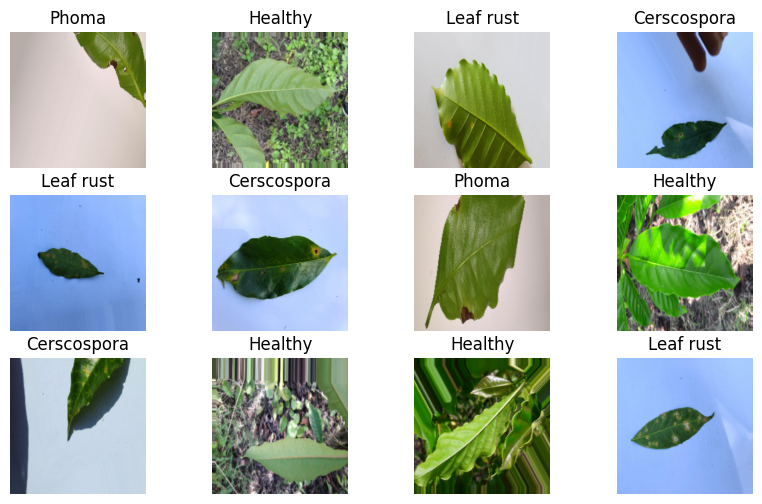

In [7]:
def display_random_images(data, class_names, num_images=12, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    
    # Get an iterator for the data generator
    data_iter = iter(data)

    for i in range(num_images):
        images, labels = next(data_iter)
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[0]) 
        plt.title(class_names[np.argmax(labels[0])])
        plt.axis('off')  # Turn off axis labels and ticks

    plt.show()
    
display_random_images(train_gen, class_names=class_names)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best model weights
)


In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Can be 'val_accuracy' or 'val_loss'
    factor=0.2,  # Factor by which to reduce the learning rate
    patience=3,  # Number of epochs with no improvement after which to reduce the learning rate
    min_lr=1e-6,  # Minimum learning rate
    verbose=1
)



In [10]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard =TensorBoard(
    log_dir='./logs',  
    histogram_freq=1, 
    write_graph=True,  
    write_images=True  
)


In [11]:
checkpoint =tf.keras.callbacks.ModelCheckpoint(
    'best_model.weights.h5', 
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


In [12]:
class_manes = ['Cerscospora', 'Healthy', 'Leaf rust', 'Phoma']

In [13]:
# Create a Sequential model
model = Sequential()

# Add Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary() 

c:\Users\dell\Desktop\fruit_detection\fruit_detection\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
optimizer  = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"],
              )

In [15]:
import warnings


# Set a higher threshold for the decompression bomb warning
warnings.filterwarnings("ignore", category=Image.DecompressionBombWarning)


history = model.fit(
    x=train_gen,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=[early_stopping, reduce_lr, tensorboard, checkpoint]
)

c:\Users\dell\Desktop\fruit_detection\fruit_detection\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6569 - loss: 0.8134
Epoch 1: val_loss improved from inf to 0.66083, saving model to best_model.weights.h5
304/304 ━━━━━━━━━━━━━━━━━━━━ 1485s 5s/step - accuracy: 0.6572 - loss: 0.8128 - val_accuracy: 0.6630 - val_loss: 0.6608 - learning_rate: 1.0000e-04
Epoch 2/5
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8258 - loss: 0.4532
Epoch 2: val_loss improved from 0.66083 to 0.52526, saving model to best_model.weights.h5
304/304 ━━━━━━━━━━━━━━━━━━━━ 1232s 4s/step - accuracy: 0.8259 - loss: 0.4531 - val_accuracy: 0.8083 - val_loss: 0.5253 - learning_rate: 1.0000e-04
Epoch 3/5
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8526 - loss: 0.3929
Epoch 3: val_loss improved from 0.52526 to 0.52424, saving model to best_model.weights.h5
304/304 ━━━━━━━━━━━━━━━━━━━━ 1162s 4s/step - accuracy: 0.8526 - loss: 0.3929 - val_accuracy: 0.7713 - val_loss: 0.5242 - learning_rate: 1.0000e-04
Epoch 4/5
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s

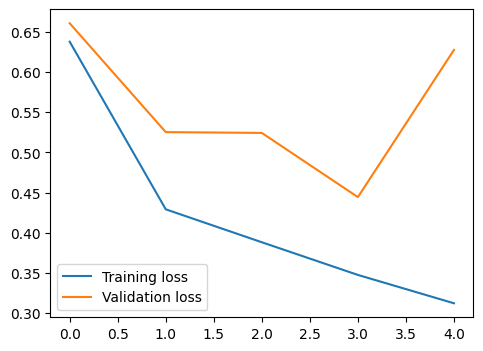

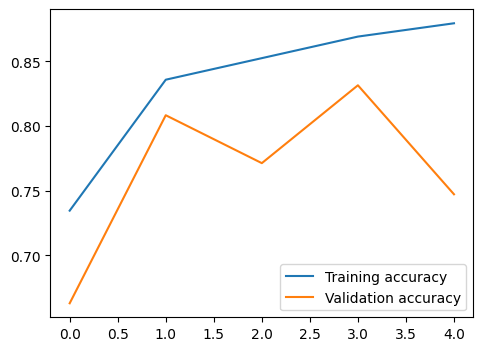

In [16]:
# plot the loss

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# Plot the accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()


In [18]:
val_loss, val_accuracy = model.evaluate(val_gen, steps=len(val_gen))
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.8386 - loss: 0.4929
Validation Loss: 0.4456
Validation Accuracy: 0.8343


In [19]:
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

34/34 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step
Confusion Matrix (NumPy Array):
[[60 87 50 73]
 [61 83 55 71]
 [57 93 46 74]
 [68 72 64 66]]


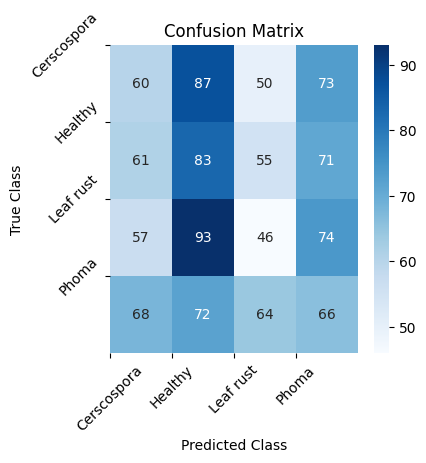

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Assuming we have predictions and true labels from our model
y_pred = model.predict(val_gen)
y_true = val_gen.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Display the confusion matrix as a NumPy array
print("Confusion Matrix (NumPy Array):")
print(cm)

# Create a visualization of the confusion matrix with class names
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)

# Set class names as tick labels
class_names = ["Cerscospora", "Healthy", "Leaf rust", "Phoma"]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names, rotation=45)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")

plt.show()